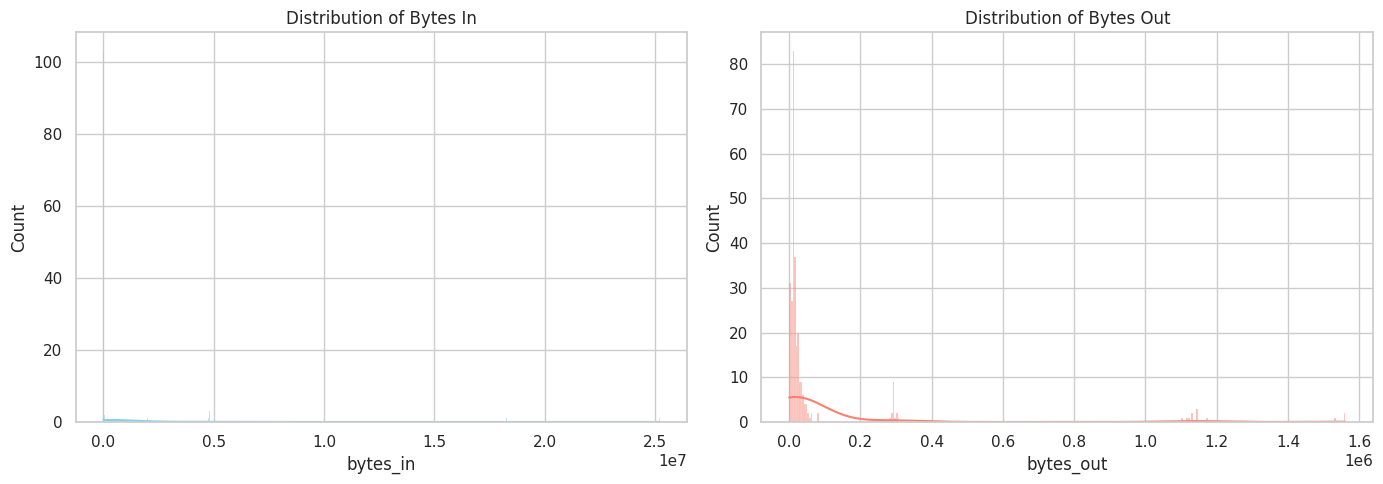

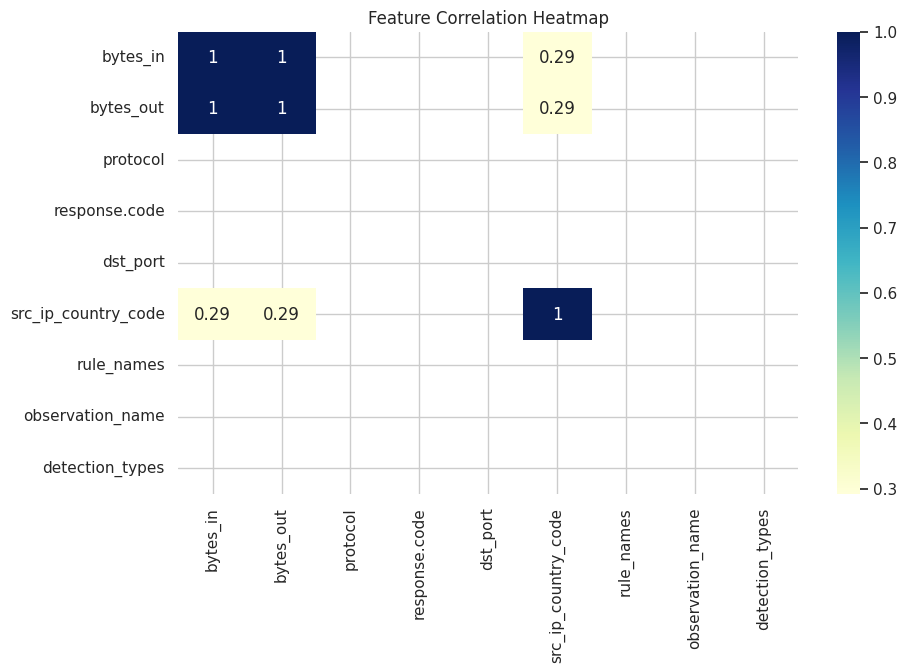

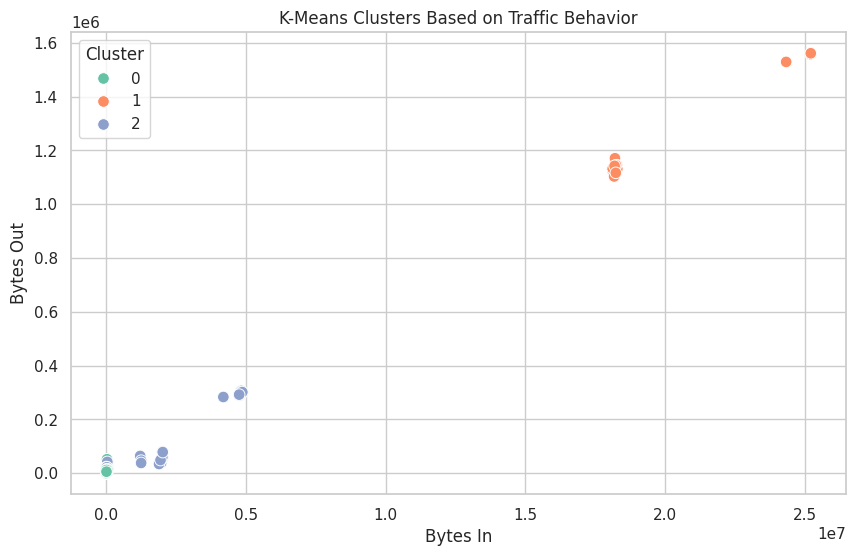

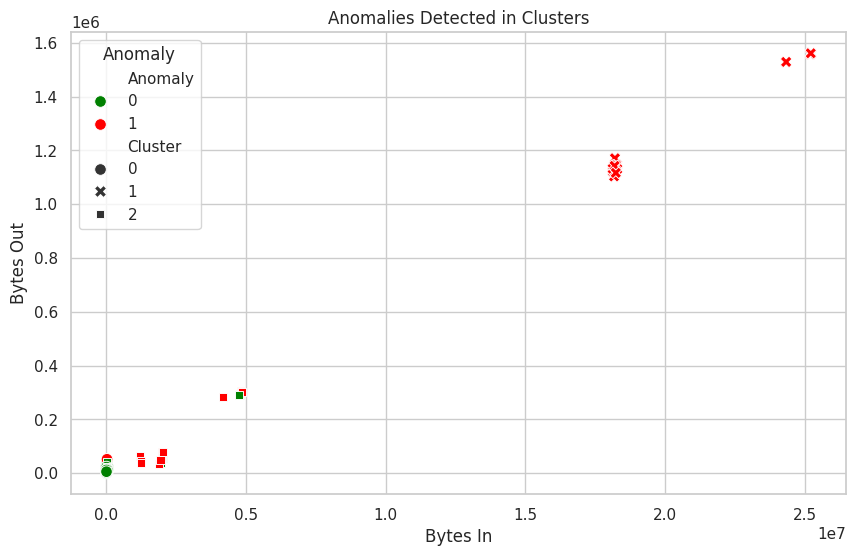

<ipython-input-1-31d3b48127b0>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Anomaly_str', palette={'0': 'green', '1': 'red'})


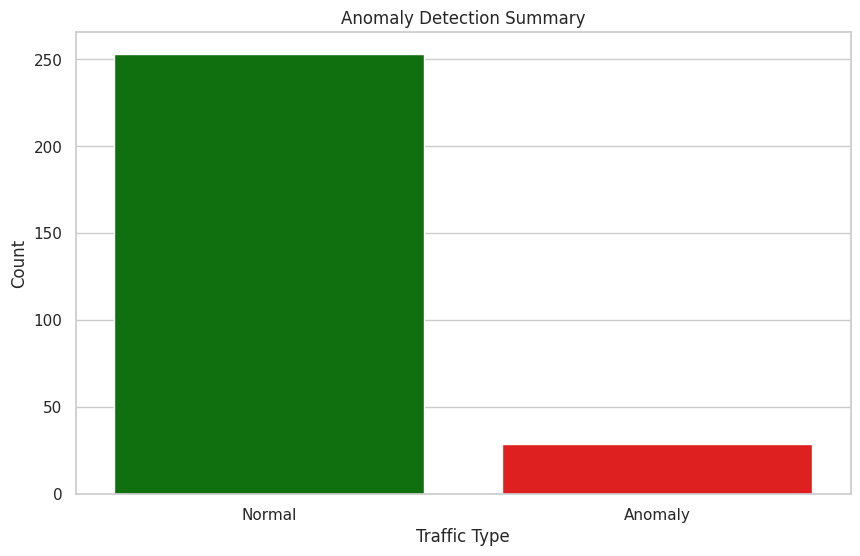

<ipython-input-1-31d3b48127b0>:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="Blues_d")


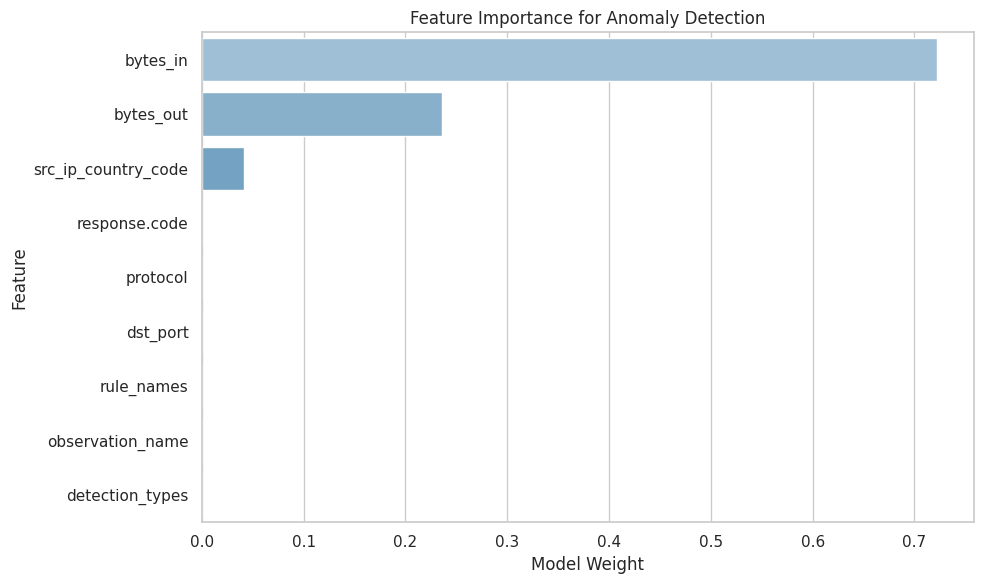

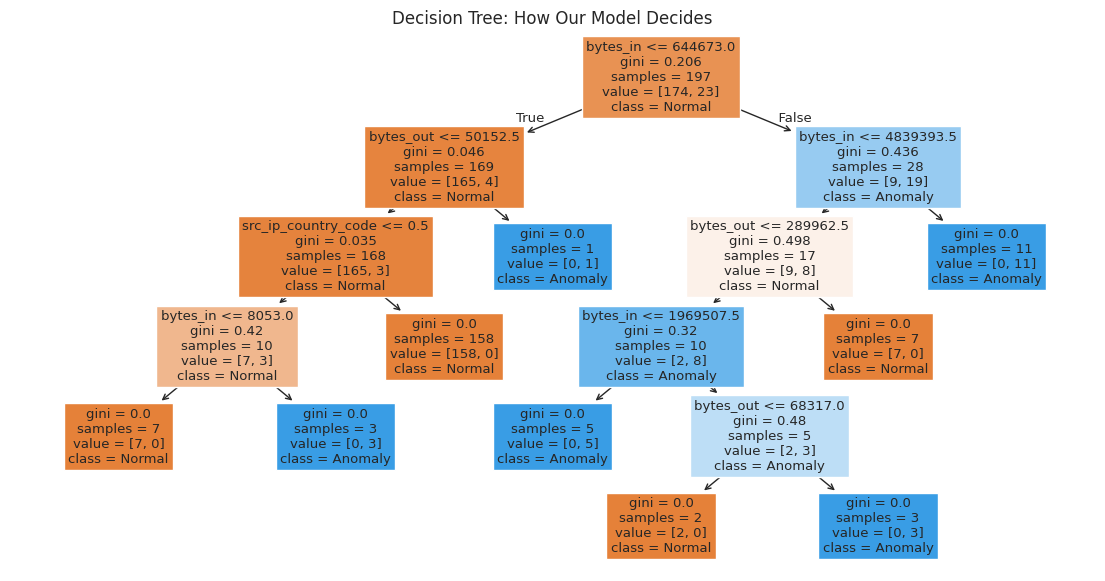


Classification Report – Decision Tree (Test Set)
Metric              Normal (0)     Anomaly (1)    
--------------------------------------------------
precision           0.96           0.75           
recall              0.99           0.50           
f1-score            0.97           0.60           
support             79             6              
--------------------------------------------------
Accuracy            0.95


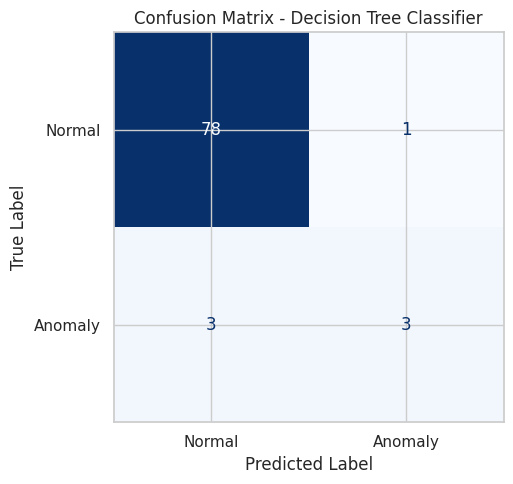

,bytes_in,bytes_out,protocol,response.code,dst_port,src_ip_country_code,rule_names,observation_name,detection_types
count,2.820000e+02,2.820000e+02,282.0,282.0,282.0,282.000000,282.0,282.0,282.0
mean,1.199390e+06,8.455429e+04,0.0,200.0,443.0,3.804965,0.0,0.0,0.0
std,4.149312e+06,2.549279e+05,0.0,0.0,0.0,2.083893,0.0,0.0,0.0
min,4.000000e+01,4.400000e+01,0.0,200.0,443.0,0.000000,0.0,0.0,0.0
25%,5.381500e+03,1.114200e+04,0.0,200.0,443.0,2.000000,0.0,0.0,0.0
50%,1.318200e+04,1.379950e+04,0.0,200.0,443.0,4.000000,0.0,0.0,0.0
75%,3.083300e+04,2.627950e+04,0.0,200.0,443.0,6.000000,0.0,0.0,0.0
max,2.520779e+07,1.561220e+06,0.0,200.0,443.0,6.000000,0.0,0.0,0.0


In [ ]:
!pip install pandas matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv") # Load and process the dataset
df_filtered = df[['bytes_in', 'bytes_out', 'protocol', 'response.code', 'dst_port',
    'src_ip_country_code', 'rule_names', 'observation_name', 'detection_types']].dropna()

label_encoders = {} # Code the categorical variables
for col in df_filtered.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_filtered[col] = le.fit_transform(df_filtered[col])
    label_encoders[col] = le

scaler = StandardScaler() # Scale and normalize numeric features
df_scaled = scaler.fit_transform(df_filtered)

fig, axes = plt.subplots(1, 2, figsize=(14, 5)) # Distribution of bytes in and out variable
sns.histplot(df['bytes_in'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Distribution of Bytes In")
sns.histplot(df['bytes_out'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title("Distribution of Bytes Out")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(df_scaled, columns=df_filtered.columns).corr(), annot=True, cmap="YlGnBu")
plt.title("Feature Correlation Heatmap")
plt.show()

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)
sns.scatterplot(x=df['bytes_in'], y=df['bytes_out'], hue=df['Cluster'], palette='Set2', s=70)
plt.title("K-Means Clusters Based on Traffic Behavior")
plt.xlabel("Bytes In")
plt.ylabel("Bytes Out")
plt.legend(title="Cluster")
plt.show()

# Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.1, random_state=42)
df['Anomaly'] = iso_forest.fit_predict(df_scaled)
df['Anomaly'] = df['Anomaly'].map({1: 0, -1: 1})  # 1 = anomaly

sns.scatterplot(
    x=df['bytes_in'], y=df['bytes_out'], hue=df['Anomaly'], style=df['Cluster'],
    palette={0: 'green', 1: 'red'}, s=70)
plt.title("Anomalies Detected in Clusters")
plt.xlabel("Bytes In")
plt.ylabel("Bytes Out")
plt.legend(title="Anomaly")
plt.show()

df['Anomaly_str'] = df['Anomaly'].astype(str) # Count anomalies
sns.countplot(data=df, x='Anomaly_str', palette={'0': 'green', '1': 'red'})
plt.title("Anomaly Detection Summary")
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.ylabel("Count")
plt.xlabel("Traffic Type")
plt.show()

X = df_filtered #Train the decision tree
y = df['Anomaly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=importances.values, y=importances.index, palette="Blues_d")
plt.title("Feature Importance for Anomaly Detection")
plt.xlabel("Model Weight")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7)) # Visualize the decision tree
plot_tree(clf, feature_names=X.columns, class_names=["Normal", "Anomaly"], filled=True)
plt.title("Decision Tree: How Our Model Decides")
plt.show()

y_pred = clf.predict(X_test) # Confusion matrix
report_dict = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n" + "="*50) # Print classification report
print("Classification Report – Decision Tree (Test Set)")
print("="*50)
print(f"{'Metric':<20}{'Normal (0)':<15}{'Anomaly (1)':<15}")
print("-" * 50)
for metric in ['precision', 'recall', 'f1-score', 'support']:
    norm = f"{report_dict['0'][metric]:.2f}" if metric != 'support' else f"{int(report_dict['0'][metric])}"
    anom = f"{report_dict['1'][metric]:.2f}" if metric != 'support' else f"{int(report_dict['1'][metric])}"
    print(f"{metric:<20}{norm:<15}{anom:<15}")
print("-" * 50)
print(f"{'Accuracy':<20}{report_dict['accuracy']:.2f}")
print("="*50)

# Visualization of Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test,
    display_labels=["Normal", "Anomaly"],
    cmap="Blues",
    ax=ax, colorbar=False)
plt.title("Confusion Matrix - Decision Tree Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

df_filtered.describe()






In [ ]:
if 'src_ip_country_code' in label_encoders:
    df['src_ip_country_code_label'] = label_encoders['src_ip_country_code'].inverse_transform(
        df_filtered['src_ip_country_code']
    )
else:
    df['src_ip_country_code_label'] = df['src_ip_country_code']

# Count of sessions per country
country_counts = df['src_ip_country_code_label'].value_counts().reset_index()
country_counts.columns = ['Country Code', 'Session Count']
print(country_counts)


  Country Code  Session Count
0           US            113
1           CA             72
2           DE             28
3           AT             21
4           NL             18
5           AE             16
6           IL             14


In [ ]:

!pip install gradio

import gradio as gr

#Drop down menu GUI
dropdown_options = {
    col: sorted(df[col].dropna().unique()) for col in [
        'protocol', 'response.code', 'dst_port', 'src_ip_country_code',
        'rule_names', 'observation_name', 'detection_types']
}

def detect_anomaly(bytes_in, bytes_out, protocol, response_code, dst_port,
                   src_ip_country_code, rule_names, observation_name, detection_types):
    try:
        row = pd.DataFrame([[
            bytes_in, bytes_out, protocol, response_code, dst_port,
            src_ip_country_code, rule_names, observation_name, detection_types
        ]], columns=df_filtered.columns)

        for col in row.columns:
            if col in label_encoders:
                row[col] = label_encoders[col].transform(row[col])

        row_scaled = scaler.transform(row)
        pred = iso_forest.predict(row_scaled)
        return "🚨 Anomaly Detected" if pred[0] == -1 else "✅ Normal Traffic"
    except Exception as e:
        return f"Error: {str(e)}"

# Gradio demo setup
demo = gr.Interface(
    fn=detect_anomaly,
    inputs=[
        gr.Number(label="Bytes In"),
        gr.Number(label="Bytes Out"),
        gr.Dropdown(choices=dropdown_options['protocol'], label="Protocol"),
        gr.Dropdown(choices=[str(x) for x in dropdown_options['response.code']], label="HTTP Response Code"),
        gr.Dropdown(choices=[str(x) for x in dropdown_options['dst_port']], label="Destination Port"),
        gr.Dropdown(choices=dropdown_options['src_ip_country_code'], label="Country Code"),
        gr.Dropdown(choices=dropdown_options['rule_names'], label="Rule Name"),
        gr.Dropdown(choices=dropdown_options['observation_name'], label="Observation Name"),
        gr.Dropdown(choices=dropdown_options['detection_types'], label="Detection Type")
    ],
    outputs="text",
    title="🔍 Web Traffic Anomaly Detector",
    description="Input real-world traffic details to see if the activity is normal or anomalous.")

demo.launch(share=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.0 MB/s eta 0:00:00
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://621f9b19fd61174e95.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
